# DCGAN

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Any
from PIL import Image
from datetime import datetime
from torchvision.transforms import ToTensor, Compose, Normalize
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import time
from torch.nn import Conv2d, BatchNorm2d, ReLU, MaxPool2d, Sequential, Sigmoid, Upsample, ModuleList, LeakyReLU, Linear
import matplotlib.pyplot as plt
from typing import Any
import torch.optim as optim

In [2]:
# Setting seeds

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

set_seeds(19890)

## Inputs

Let’s define some inputs for the run:

-  ``workers`` - the number of worker threads for loading the data with
   the ``DataLoader``.
-  ``batch_size`` - the batch size used in training. The DCGAN paper
   uses a batch size of 128.
-  ``image_size`` - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   [here](https://github.com/pytorch/examples/issues/70)_ for more
   details.
-  ``nc`` - number of color channels in the input images. For color
   images this is 3.
-  ``nz`` - length of latent vector.
-  ``ngf`` - relates to the depth of feature maps carried through the
   generator.
-  ``ndf`` - sets the depth of feature maps propagated through the
   discriminator.
-  ``num_epochs`` - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer.
-  ``lr`` - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002.
-  ``beta1`` - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5.
-  ``ngpu`` - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs.
-  ``GDRIVE`` - Set to True if the (already preprocessed) raw image/mask dataset is stored in a Google Drive personal folder (with path specified some cells below). False if the dataset is stored locally.




In [3]:
# Number of workers for dataloader
workers = 2

# Batch size used to split the dataset and train the model [128 in Default DCGAN]
batch_size = 256

# Image size as input to the model (either 64 or 256)
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input) [100 in Default DCGAN]
nz = 100

# Size of feature maps in generator [64 in Default DCGAN]
ngf = 16

# Size of feature maps in discriminator [64 in Default DCGAN]
ndf = 64

# Number of training epochs
num_epochs = 60

# Learning rate for optimizers [0.0002 in Default DCGAN]
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers [0.5 in Default DCGAN]
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Use dataset stored on Google Drive personal folder if True, use local dataset if False
GDRIVE = True

# Avoid printing images used to train the model if True, shows em if False.
CENSOR = False


config = {
    "architecture":"DCGAN-resizeconv",
    "nc": nc,
    "nz": nz,
    "ngf": ngf,
    "ndf": ndf,
    "num_epochs": num_epochs,
    "lr": lr,
    "beta1": beta1,
    "ngpu": ngpu,
    }

## Dataset creation

Our dataset is made up of image-color mask pairs.  
The objective of the model is to learn the mapping from the latter to the former.

In [4]:
class TanhRescaler(object):
    def __call__(self, input_data):
        # Assuming input_data is a PyTorch tensor
        transformed_data = input_data * 2 - 1
        return transformed_data

class MaskPairDataset(Dataset):
    '''
    Custom PyTorch dataset class for handling paired image-mask data.

    Args:
        base_folder (Path): The base folder containing the image and mask pairs.
        transforms (callable, optional): Transforms to be applied to the input images. Default is None.
        mask_transforms (callable, optional): Transforms to be applied to the masks. Default is None.
        suffix (str, optional): The suffix added to image filenames to obtain corresponding mask filenames. Default is "_mask".
        is_mask_rgb (bool, optional): Flag indicating whether the masks are in RGB format. Default is False.
        mask (bool, optional): Flag indicating whether the dataset includes masks. Default is False.

    Attributes:
        transforms (callable): Transforms to be applied to the input images.
        mask_transforms (callable): Transforms to be applied to the masks.
        is_mask_rgb (bool): Flag indicating whether the masks are in RGB format.
        mask (bool): Flag indicating whether the dataset includes masks.
        img_list (list): List of image file paths.
        paired_data (list): List of paired image and mask file paths.

    Methods:
        __len__(self) -> int:
            Returns the total number of paired image-mask data in the dataset.

        __getitem__(self, index) -> Dict:
            Retrieves an item (image and its corresponding mask) by index.
    '''

    def __init__(self, base_folder : Path,
                 transforms = None,
                 mask_transforms = None,
                 suffix:str = "_mask",
                 is_mask_rgb:bool = False,
                 mask=False):

        self.transforms = transforms
        self.mask_transforms = mask_transforms
        self.is_mask_rgb = is_mask_rgb
        self.mask = mask
        self.img_list = []

        # Get all png images in the folder
        self.img_list = base_folder.glob("*.png")
        # Remove the masks
        self.img_list = [img for img in self.img_list if "mask" not in img.name]

        # Create the pairs
        self.paired_data = []

        if self.mask:
          for img in self.img_list:
              supposed_mask = base_folder / (img.stem + suffix + ".png")
              if supposed_mask.is_file():
                  self.paired_data.append((img, supposed_mask))

    def __len__(self) -> int:
        '''
        Returns the total number of paired image-mask data in the dataset.

        Returns:
            int: Length of paired data.
        '''
        if self.mask:
          return len(self.paired_data)
        else:
          return len(self.img_list)


    def __getitem__(self, index) -> Dict:
        '''
        Retrieves an item (image and its corresponding mask) by index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            Dict: A dictionary containing 'img' (image) and 'mask' (corresponding mask).
        '''

        if self.mask:
            img_path, mask_path = self.paired_data[index]
            img = Image.open(img_path).convert("RGB")
            if self.is_mask_rgb:
                mask = Image.open(mask_path).convert("RGB")
            else:
                mask = Image.open(mask_path).convert("L")
        else:
            img_path = self.img_list[index]
            img = Image.open(img_path).convert("RGB")

        # Apply transforms
        if self.transforms:
            # Make sure that random transforms to both image and mask behave in the same way
            seed = np.random.randint(2147483647)

            random.seed(seed)
            torch.manual_seed(seed)
            img = self.transforms(img)

            random.seed(seed)
            torch.manual_seed(seed)

        if self.mask_transforms and self.mask:
                mask = self.transforms(mask)

        if self.mask:
            return {"img":img, "mask":mask}
        else:
            return {"img":img}

In [5]:
import os
# accessing GDrive preprocessed dataset folder
if GDRIVE:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)

    # accessing dataset folder and printing files contained in it
    os.chdir('./gdrive/MyDrive/AII Project/experiments-synthetic-generation-clinical-skin-images-main')
    !ls

Mounted at /content/gdrive/
 crops		     evaluation		      lightning_logs   outputs-gan    VAE_128_GANloss
 dataset	     generate_images.ipynb    logs	       saved_models   wandb
'Dataset Analysis'   GLIDE_256.ipynb	      low_contrast     test_images
 DCGAN_128.ipynb     glide_generated_images   Old	       VAE_128


In [7]:
# Building the dataset and dataloader (just rerun in case of errors for input/output)
import torchvision.transforms as transforms

base_folder = Path("./crops")

if image_size != 256:
    transforms = transforms.Compose([transforms.CenterCrop((image_size,image_size)), ToTensor(), TanhRescaler()])


else:
    transforms = transforms.Compose([ToTensor(), TanhRescaler()])



dataset = MaskPairDataset(base_folder, transforms=transforms, suffix="_mask2", is_mask_rgb=True)#, img_norm=Normalize(mean=means, std=stds), mask_norm=Normalize(mean=[0.5], std=[0.5]))

print('This dataset contains {} samples, with dimension {}'.format(len(dataset),dataset[0]['img']))


This dataset contains 11994 samples, with dimension tensor([[[-0.0353, -0.0353, -0.0353,  ...,  0.0275,  0.0275,  0.0039],
         [-0.0275, -0.0196, -0.0275,  ...,  0.0353,  0.0353,  0.0039],
         [-0.0510, -0.0039,  0.0039,  ...,  0.0118,  0.0196,  0.0039],
         ...,
         [ 0.0824,  0.0824,  0.0745,  ...,  0.0902,  0.1059,  0.1137],
         [ 0.0824,  0.0824,  0.0824,  ...,  0.0824,  0.0980,  0.1059],
         [ 0.0667,  0.0745,  0.0824,  ...,  0.0745,  0.0824,  0.0902]],

        [[-0.2549, -0.2549, -0.2549,  ..., -0.1765, -0.1765, -0.2000],
         [-0.2471, -0.2392, -0.2471,  ..., -0.1686, -0.1686, -0.2000],
         [-0.2549, -0.2078, -0.2000,  ..., -0.1922, -0.1843, -0.2000],
         ...,
         [-0.1216, -0.1216, -0.1294,  ..., -0.1608, -0.1451, -0.1373],
         [-0.1216, -0.1216, -0.1216,  ..., -0.1686, -0.1608, -0.1529],
         [-0.1373, -0.1294, -0.1216,  ..., -0.1765, -0.1765, -0.1686]],

        [[-0.3490, -0.3490, -0.3490,  ..., -0.2784, -0.2784, -0.

In [8]:
# visualizing a transformed sample (remember that ToTensor() maps from [0-255] to [-1,1])
dataset[0]

{'img': tensor([[[-0.0353, -0.0353, -0.0353,  ...,  0.0275,  0.0275,  0.0039],
          [-0.0275, -0.0196, -0.0275,  ...,  0.0353,  0.0353,  0.0039],
          [-0.0510, -0.0039,  0.0039,  ...,  0.0118,  0.0196,  0.0039],
          ...,
          [ 0.0824,  0.0824,  0.0745,  ...,  0.0902,  0.1059,  0.1137],
          [ 0.0824,  0.0824,  0.0824,  ...,  0.0824,  0.0980,  0.1059],
          [ 0.0667,  0.0745,  0.0824,  ...,  0.0745,  0.0824,  0.0902]],
 
         [[-0.2549, -0.2549, -0.2549,  ..., -0.1765, -0.1765, -0.2000],
          [-0.2471, -0.2392, -0.2471,  ..., -0.1686, -0.1686, -0.2000],
          [-0.2549, -0.2078, -0.2000,  ..., -0.1922, -0.1843, -0.2000],
          ...,
          [-0.1216, -0.1216, -0.1294,  ..., -0.1608, -0.1451, -0.1373],
          [-0.1216, -0.1216, -0.1216,  ..., -0.1686, -0.1608, -0.1529],
          [-0.1373, -0.1294, -0.1216,  ..., -0.1765, -0.1765, -0.1686]],
 
         [[-0.3490, -0.3490, -0.3490,  ..., -0.2784, -0.2784, -0.3020],
          [-0.3412, -

## Data

Here we create training batches from the original dataset


In [9]:
import torchvision.utils as vutils

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         pin_memory = torch.cuda.is_available(),
                                         shuffle=True, num_workers=workers)

## Generator

The generator, $G$, is designed to map the latent space vector
($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.

.. figure:: /_static/img/dcgan_generator.png
   :alt: dcgan_generator

Notice, how the inputs we set in the input section (``nz``, ``ngf``, and
``nc``) influence the generator architecture in code. ``nz`` is the length
of the z input vector, ``ngf`` relates to the size of the feature maps
that are propagated through the generator, and ``nc`` is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.




In [10]:
import torch.nn as nn
# Generator Code

class Generator(nn.Module):

    def convblock_resizeconv(self, in_channels, out_channels, scale_factor=2):
        '''
        https://distill.pub/2016/deconv-checkerboard/
        '''
        block =  nn.Sequential(
            nn.Upsample(scale_factor = scale_factor, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(out_channels, out_channels, 4, 1, bias=False, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Dropout2d(0.2),)

        return block

    def convblock_out(self, in_channels, out_channels):
        '''
        https://distill.pub/2016/deconv-checkerboard/
        '''
        block =  nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='bilinear'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),)

        return block

    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            self.convblock_resizeconv(in_channels=nz, out_channels=ngf*32),
            # state size. ``(ngf*32) x 2 x 2``
            self.convblock_resizeconv(in_channels=ngf*32, out_channels=ngf*16),
            # state size. ``(ngf*16) x 4 x 4``
            self.convblock_resizeconv(in_channels=ngf*16, out_channels=ngf*8),
            # state size. ``(ngf*8) x 8 x 8``
            self.convblock_resizeconv(in_channels=ngf*8, out_channels=ngf*4),
            # state size. ``(ngf*4) x 16 x 16``
            self.convblock_resizeconv(in_channels=ngf*4, out_channels=ngf*2),
            # state size. ``(ngf*2) x 32 x 32``
            self.convblock_resizeconv(in_channels=ngf*2, out_channels=ngf),
            # state size. ``(ngf) x 64 x 64``
            self.convblock_out(in_channels=ngf, out_channels=nc),
            nn.Tanh(),
            # state size. ``(nc) x 128 x 128``
            )

    def forward(self, input):
        return self.main(input)


def test_gen_sizes(generator):
    '''
    Test Generator Output Sizes

    This function tests the output size of a generator by generating images
    from a sample noise vector and checking if the generated images match
    the expected shape.

    Args:
    - generator: The generator model to test.

    Returns:
    - None
    '''

    # size 1 batch of input noise
    sample_noise = torch.randn(batch_size, nz, 1, 1).to(device)

    # Generate images from the noise vector using the generator
    with torch.no_grad():
        generated_images = generator(sample_noise)

    # Check the size of the generated images
    expected_shape_out = list(generated_images.shape)
    actual_shape_out = [batch_size, nc, image_size, image_size]

    assert expected_shape_out == actual_shape_out
    print("Generated images shape:", expected_shape_out, 'corresponding to [batch_size, nc, image_dim, image_dim]')


In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Load pretrained weights
netG = torch.load('./evaluation/weights_netG_DCGAN_128.pt', map_location=torch.device(device))

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)

# testing generator architecture
test_gen_sizes(netG)

Generator(
  (main): Sequential(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): ReflectionPad2d((1, 1, 1, 1))
      (2): Conv2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
      (3): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout2d(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): ReflectionPad2d((1, 1, 1, 1))
      (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=same, bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout2d(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


Generated images shape: [256, 3, 128, 128] corresponding to [batch_size, nc, image_dim, image_dim]


In [12]:
# print model summary
from torchvision import models
from torchsummary import summary

summary(netG, (nz,1,1), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1           [256, 100, 2, 2]               0
   ReflectionPad2d-2           [256, 100, 4, 4]               0
            Conv2d-3           [256, 512, 2, 2]         461,312
            Conv2d-4           [256, 512, 2, 2]       4,194,304
       BatchNorm2d-5           [256, 512, 2, 2]           1,024
              ReLU-6           [256, 512, 2, 2]               0
         Dropout2d-7           [256, 512, 2, 2]               0
          Upsample-8           [256, 512, 4, 4]               0
   ReflectionPad2d-9           [256, 512, 6, 6]               0
           Conv2d-10           [256, 256, 4, 4]       1,179,904
           Conv2d-11           [256, 256, 4, 4]       1,048,576
      BatchNorm2d-12           [256, 256, 4, 4]             512
             ReLU-13           [256, 256, 4, 4]               0
        Dropout2d-14           [256, 25

## Test

average time per image: 0.03310761135071516


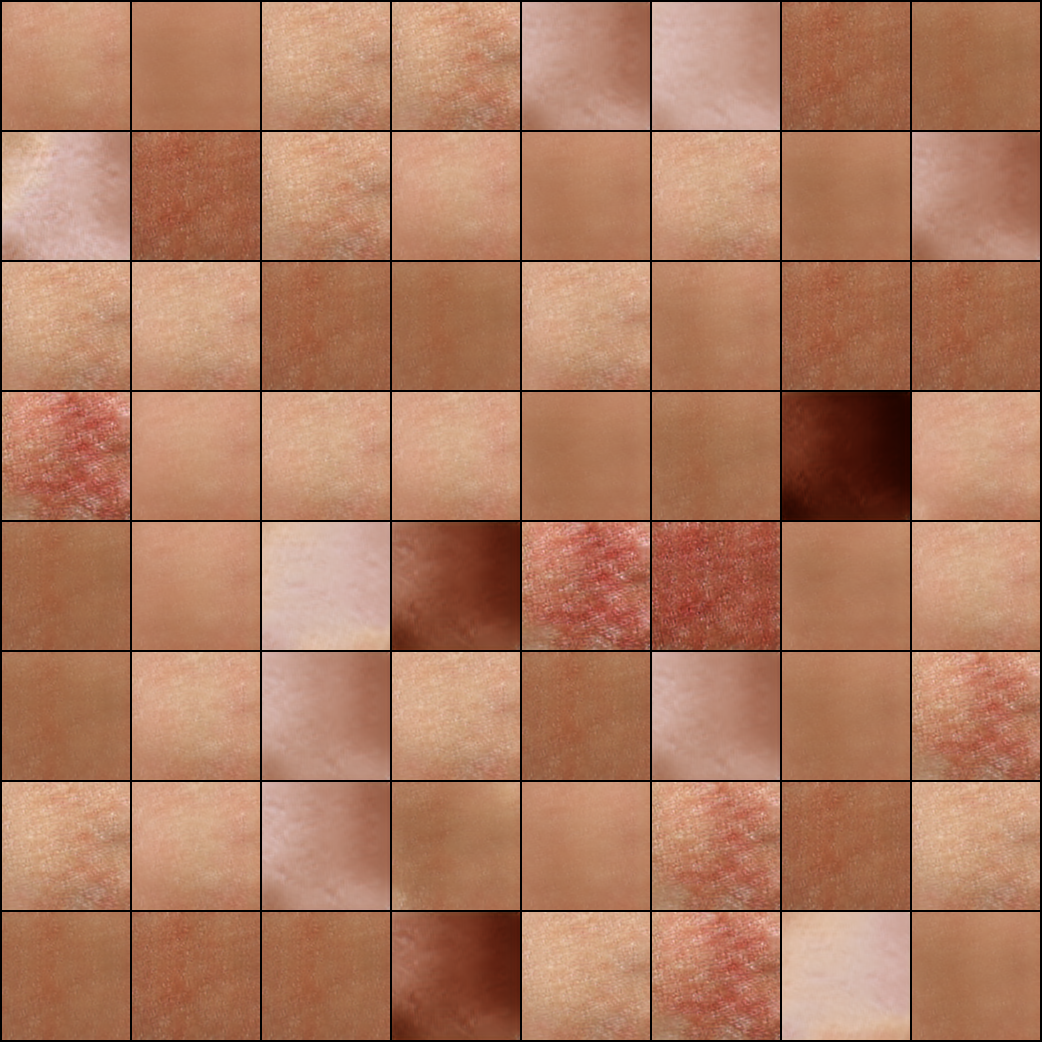

In [13]:
# generating a batch of images and computing elapsed time to produce an image


img_list = []
batch_size_test = 512
fixed_noise = torch.randn(batch_size_test, nz, 1, 1, device=device)

netG.eval()
with torch.no_grad():
    start_time = time.time()
    fake = netG(fixed_noise).detach().cpu()
    img_grid = vutils.make_grid(fake[:64], padding=2, normalize=True)
    transform = T.ToPILImage()
    fake_img = transform(img_grid)
    end_time = time.time()

print(f'average time per image: {(end_time-start_time)/batch_size_test}')
fake_img

## FID evaluation

In [14]:
!pip install pip install torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 5.4 MB/s eta 0:00:00


In [15]:
# FID evaluation
# Take all training examples, I know it's overfitting but w.e.
# Instantatiate FID object

import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(normalize=True).to(device)


for i, batch in enumerate(tqdm.tqdm(dataloader)):

    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    generator = netG.to(device)
    generator.eval()
    with torch.no_grad():
        generated_images = generator(fixed_noise)

    fid.update(generated_images, real=False)
    fid.update(batch["img"].to(device), real=True)

print(f"FID:{fid.compute()}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 206MB/s]
100%|██████████| 47/47 [3:37:28<00:00, 277.62s/it]


FID:103.89852142333984
